In [2]:
# Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Dataset Directories
dataset = r"c:\Users\kimry\OneDrive\Desktop\DjangoTrainProject\core\ml_model/data_collection/filipino_food"
dataset_dir = r"c:\Users\kimry\OneDrive\Desktop\DjangoTrainProject\core\ml_model/data_collection/filipino_food_split"
trainpath = os.path.join(dataset_dir, "train")
validpath = os.path.join(dataset_dir, "val")
testpath = os.path.join(dataset_dir, "test")

# Image Parameters
img_width, img_height = 224, 224
batch_size = 20

# Step 2: Dataset Preparation
import splitfolders
splitfolders.ratio(
    dataset,
    output=dataset_dir,
    seed=1337,
    ratio=(0.8, 0.1, 0.1),
    group_prefix=None,
    move=False
)

print("Dataset split completed!")

Copying files: 8383 files [00:19, 427.81 files/s]

Dataset split completed!


In [ ]:
# Step 3: Data Preprocessing and Augmentation
train_data_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_set = train_data_generator.flow_from_directory(
    trainpath,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

valid_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_set = valid_data_generator.flow_from_directory(
    validpath,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

test_data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)
test_set = test_data_generator.flow_from_directory(
    testpath,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Print dataset summary
print(f"Train samples: {train_set.samples}")
print(f"Validation samples: {valid_set.samples}")
print(f"Test samples: {test_set.samples}")

Found 6692 images belonging to 45 classes.
Found 817 images belonging to 45 classes.
Found 874 images belonging to 45 classes.
Train samples: 6692
Validation samples: 817
Test samples: 874


In [ ]:
# Step 4: Load Pretrained ResNet50 Model
from tensorflow.keras.regularizers import l2

base_model = ResNet50(input_shape=(img_width, img_height, 3), include_top=False, weights='imagenet')
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)
x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)  # L2 regularization
x = Dropout(0.5)(x)
output = Dense(train_set.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

# Freeze earlier layers for transfer learning
for layer in base_model.layers[:-50]:
    layer.trainable = False

In [ ]:
# Step 5: Compile Model
from keras.callbacks import EarlyStopping

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


model.summary()

# Step 6: Callbacks
checkpoint = ModelCheckpoint(
    "trained_data/filipino_food_model.keras",
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    factor=0.1,
    patience=2,
    mode='auto'
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

callbacks = [checkpoint, reduce, early_stop]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_3[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 26,233,773 (100.07 MB)

 Trainable params: 19,596,589 (74.76 MB)

 Non-trainable params: 6,637,184 (25.32 MB)

In [ ]:
# Step 7: Train the Model
epochs = 50
trained_model = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=valid_set,
    validation_steps=valid_set.samples // batch_size,
    callbacks=callbacks
)

# Step 8: Evaluate Model
train_loss, train_accuracy = model.evaluate(train_set)
val_loss, val_accuracy = model.evaluate(valid_set)
test_loss, test_accuracy = model.evaluate(test_set)

print(f"Training Accuracy: {train_accuracy:.2f}, Training Loss: {train_loss:.2f}")
print(f"Validation Accuracy: {val_accuracy:.2f}, Validation Loss: {val_loss:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}, Test Loss: {test_loss:.2f}")

# Step 9: Save Model
model.save("Filipino_Food_ResNet50_Final.h5")

c:\Users\kimry\OneDrive\Desktop\DjangoTrainProject\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
 85/334 ━━━━━━━━━━━━━━━━━━━━ 7:08 2s/step - accuracy: 0.0175 - loss: 24.3014

c:\Users\kimry\OneDrive\Desktop\DjangoTrainProject\env\Lib\site-packages\PIL\Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.0454 - loss: 22.9064

c:\Users\kimry\OneDrive\Desktop\DjangoTrainProject\env\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Epoch 1: val_loss improved from inf to 17.76548, saving model to trained_data/filipino_food_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 684s 2s/step - accuracy: 0.0455 - loss: 22.9013 - val_accuracy: 0.2663 - val_loss: 17.7655 - learning_rate: 1.0000e-04
Epoch 2/50
  1/334 ━━━━━━━━━━━━━━━━━━━━ 22:27 4s/step - accuracy: 0.1500 - loss: 17.8149

C:\Users\kimry\AppData\Local\Programs\Python\Python311\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_loss did not improve from 17.76548
334/334 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.1500 - loss: 17.8149 - val_accuracy: 0.0000e+00 - val_loss: 18.0848 - learning_rate: 1.0000e-04
Epoch 3/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.2181 - loss: 16.6976
Epoch 3: val_loss improved from 17.76548 to 13.27851, saving model to trained_data/filipino_food_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 0.2181 - loss: 16.6942 - val_accuracy: 0.3675 - val_loss: 13.2785 - learning_rate: 1.0000e-04
Epoch 4/50
  1/334 ━━━━━━━━━━━━━━━━━━━━ 9:27 2s/step - accuracy: 0.5000 - loss: 13.0477
Epoch 4: val_loss improved from 13.27851 to 13.21201, saving model to trained_data/filipino_food_model.keras
334/334 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.5000 - loss: 13.0477 - val_accuracy: 0.2941 - val_loss: 13.2120 - learning_rate: 1.0000e-04
Epoch 5/50
334/334 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3548 - loss: 12.5688
Epoch 5: val_loss improve

Training Accuracy: 0.84, Training Loss: 1.54
Validation Accuracy: 0.48, Validation Loss: 3.50
Test Accuracy: 0.43, Test Loss: 3.87


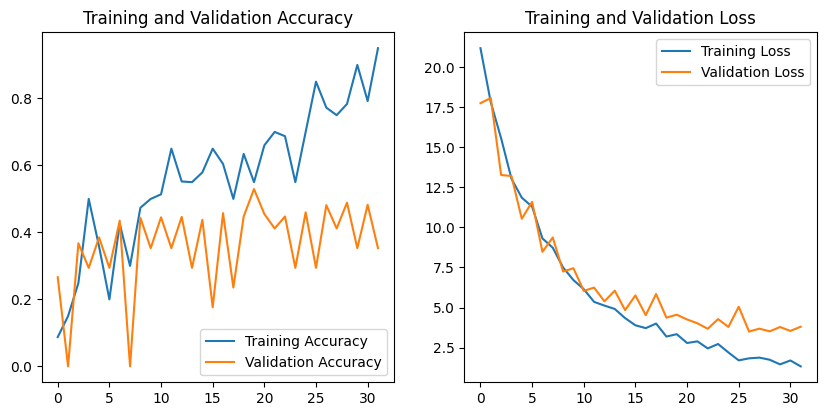

In [ ]:
# Step 10: Visualize Training History
acc = trained_model.history['accuracy']
val_acc = trained_model.history['val_accuracy']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

# Adjust the range to match the actual number of epochs completed
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot training and validation loss
plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Step 11: Load Model for Testing
import tensorflow as tf
new_model = tf.keras.models.load_model("Filipino_Food_ResNet50_Final.h5")
print("Model reloaded for testing.")

Model reloaded for testing.
